In [1]:
# import some necessary stuff

In [3]:
# from dask.distributed import Client

# client = Client("tcp://10.32.15.52:42529")
# client

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline
import xarray as xr
import intake
import util
import warnings
from cmip6_preprocessing.preprocessing import read_data

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [6]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28665 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28665 zstore(s)

	> 59 dcpp_init_year(s)

In [7]:
# read all data with volume and oxygen
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict = read_data(col,
                    experiment_id=['piControl'],
                    grid_label='gn',
                    variable_id=['o2','thkcello', 'areacello'],
                    member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['o2', 'thkcello', 'areacello']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 15 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [8]:
data_dict['IPSL-CM6A-LR']

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, lev: 75, member_id: 1, nvertex: 4, time: 500, x: 362, x_right: 362, y: 332, y_right: 332)
Coordinates:
  * time           (time) object 1850-07-02 12:00:00 ... 2349-07-02 12:00:00
  * lev            (lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * member_id      (member_id) <U8 'r1i1p1f1'
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360 361
  * x_right        (x_right) float64 0.5 1.5 2.5 3.5 ... 358.5 359.5 360.5 361.5
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330 331
  * y_right        (y_right) float64 0.5 1.5 2.5 3.5 ... 328.5 329.5 330.5 331.5
    dxe            (y, x_right) float64 1.127e+04 1.127e+04 ... 777.7 777.7
    dyn            (y_right, x) float64 1.136e+04 1.136e+04 ... 1.49e+07
    dxt            (y, x) float64 1.127e+04 1.127e+04 ... 1.71e+03 777.7
    dxne           (y_right, x_right) float64 1.136e+04 1.136e+04 ... 6.022e+03
    dxn            

In [9]:
import numpy as np
from xhistogram.xarray import histogram
def omz_volume(o2, vol, o2_bins, dim=['x', 'y', 'lev']):
    nanmask = np.isnan(o2)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        o2.where(~nanmask),
        bins=[o2_bins],
        weights=vol.where(~nanmask),
        dim=dim,
    )
    return full_sum

In [10]:
o2_bins = np.arange(0,300,10)
ds_test = data_dict['IPSL-CM6A-LR']
vol = ds_test.areacello * ds_test.thkcello
o2 = ds_test.o2 * 1e3 # convert to mumol

omz_vol = omz_volume(o2, vol, o2_bins)

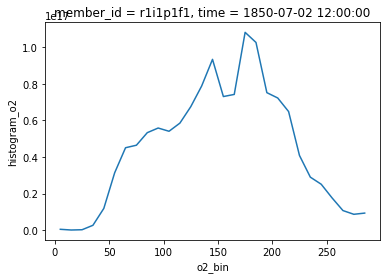

In [11]:
omz_vol.isel(time=0).plot()

In [12]:
omz_80 = omz_vol.cumsum('o2_bin').sel(o2_bin=80, method='nearest')

In [1]:
omz_80.plot()

NameError: name 'omz_80' is not defined